# understand through impementation: back-propagation in numpy

Shaobo Guan, 
2018-0509

based on Imad Dabbura:

https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76

https://nbviewer.jupyter.org/github/ImadDabbura/blog-posts/blob/master/notebooks/Coding-Neural-Network-Forwad-Back-Propagation.ipynb

In [1]:
%matplotlib inline
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1 Coding the Neural Network

## 1.1 Forward Propagation


$$ Z^l = W^l A^{l-1} + b^l $$

$$ A^l = g(Z^l) = g( W^l A^{l-1} + b^l) $$

### Notations:


| variable | details |
| ---   | :--- |
| $W^l$ | weight matrix of layer l
| $b^l$ | Bias vector for layer l
| $Z^l$ | affine/linear transformation at layer l, activity before activation function
| $g^l$ | activation function of layer l
| $A^l$ | post-activation output of layer l
| $J$   | cost function
| $dW^l$| derivative of cost function w.r.t. $W^l$, i.e. $\frac{\partial J}{\partial W^l}$, similarly, for $d b^l, d Z^l, dA^l$
| $n^l$ | number of units at layer l
| $m$   | number of examples (data)
| $L$   | number of layers (not including input layer)

### Demensions of the model

| variables | dimension |
| :----------------------------- | :-------------------- |
| $Z^l$, $A^l$, $d Z^l$, $d A^l$ | $ n^l \times m$       |
| $W^l$, $d W^l$                 | $ n^l \times n^{l-1}$ |
| $b^l$, $d b^l$                 | $ n^l \times 1$       |


## 1.2 Parameter Initialization

* should be non-zero to break symmerty
* make sure the before activation activity is for units is in the sensative range


In [2]:
""" initialize parameters """

def initialize_parameters(layers_dims):
    """
    layers_dims: number of units at every layer
    returns: all parameters
    """
    scaler = 0.01
    np.random.seed(1)
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        nl = layers_dims[l]
        parameters['W{}'.format(l)] = np.random.randn(nl, layers_dims[l-1]) * scaler
        parameters['b{}'.format(l)] = np.random.randn(nl, 1)
    return parameters

## 1.3 Activtion Function

### sigmoild:
$$g(z) =   \frac{1}{1+e^{-z}} $$ 
* links to probability, in range $[0, 1]$
* small gradient when far away from zero, slow to learn
    
### hyperbolic tangent: 
$$ g(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}} $$
* center around zero
* small gradient when far away from zero, slow to learn

### rectified linear unit (ReLU):
$$ g(z) = \max{(0, z)} $$
* easy to compute
* no vanishing gradient problem when $z>0$

### leakey rectified linear unit:
$$ g(z) = \max{(\alpha z, z)} $$
* can still learn when z is small


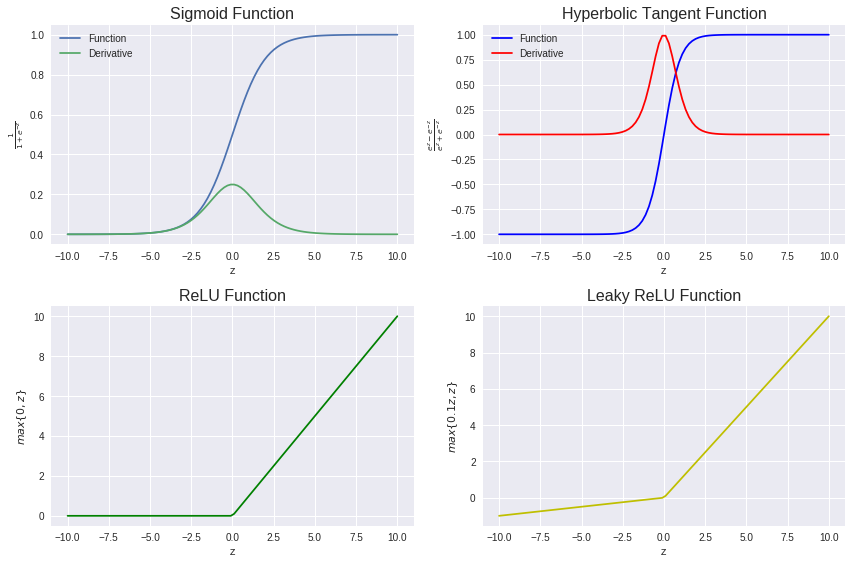

In [3]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = 1 / (1 + np.exp(-Z))

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z elemnet-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z


# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

## 1.4 Forward Propagation

The key here is to keep a copy *cache* for later back propagation

In [4]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
    cache : tuple
        stores A_prev, W, b to be used in backpropagation.
    """
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
    """
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation_fn == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation_fn == "tanh":
        A, activation_cache = tanh(Z)
    elif activation_fn == "relu":
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)
        
    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)
    
    assert AL.shape == (1, X.shape[1])

    return AL, caches

## 1.5 Cost function

here we use cross-entropy

$$ J(W, b) = -\frac{1}{m}\sum_{i=1}^m{H(y_i, \hat{y}_i)} = -\frac{1}{m}\sum_{i=1}^m{\bigg( (y^i \log(\hat{y}_i)) + (1-y^i)\log{(1-\hat{y}^i)} \bigg)} $$

In [5]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    m = y.shape[1]
    cost = - (1 / m) * np.sum( np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return cost

## 1.6 Back-Propagation

### 1.6.1 list of derivatives based on chain rule

$$
\begin{align}
dA^L &  = \frac{\partial J}{\partial A^L} = \frac{A^L-Y}{A^L(1-A^L)}  \\
dZ^L & = \frac{\partial J}{\partial A^L} \frac{\partial A^L}{\partial Z^L} = \frac{A^L-Y}{A^L(1-A^L)} A^L (1-A^L) = A^L-Y  \\
dW^l & = \frac{\partial J}{\partial Z^l} \frac{\partial Z^l}{\partial W^l} = \frac{1}{m} dZ^l {A^{l-1}}^T  \\
db^l & = \frac{\partial J}{\partial Z^l} \frac{\partial Z^l}{\partial b^l} = \frac{1}{m} \sum_i dZ^l  \\
dA^{l-1} & = \frac{\partial J}{\partial Z^l} \frac{\partial Z^l}{\partial A^{l-1}} = {W^l}^T dZ^l   \\
dZ^l & = \frac{\partial J}{\partial A^l} \frac{\partial A^l}{\partial Z^l} = dA^l \frac{\partial g(Z^l)}{\partial Z^l}
\end{align} 
$$

### 1.6.2 implimentation


In [6]:
# Define derivative of activation functions w.r.t z that will be used in back-propagation
def sigmoid_gradient(dA, Z):
    """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    """
    Computes the gradient of hyperbolic tangent output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid", "tanh", or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
    """
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)     

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)

    dA_prev, dW, db = linear_backword(dZ, linear_cache)
        
    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
    """
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads


# define the function to update both weight matrices and bias vectors
def update_parameters(parameters, grads, learning_rate):
    """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

# 2. Application

## 2.1 process dataset

Original dimensions:
--------------------
Training: (209, 64, 64, 3), (209,)
Test: (50, 64, 64, 3), (50,)

New dimensions:
---------------
Training: (12288, 209), (1, 209)
Test: (12288, 50), (1, 50)


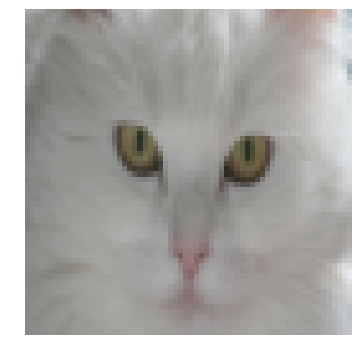

In [7]:
# Import training dataset
train_dataset = h5py.File("../data/train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
y_train = np.array(train_dataset["train_set_y"])

test_dataset = h5py.File("../data/test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
plt.figure(figsize=(6, 6))
plt.imshow(X_train[50])
plt.axis("off");

# Transform input data and label vector
X_train = X_train.reshape(209, -1).T
y_train = y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
y_test = y_test.reshape(-1, 50)

# standarize the data
X_train = X_train / 255
X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

## 2.2 define model traning

In [8]:
# Define the multi-layer model using all the helper functions we wrote before


def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000, 
    print_cost=True, hidden_layers_activation_fn="relu"):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    return f"The accuracy rate is: {accuracy:.2f}%."

## 2.3 train the model

The cost after 100 iterations is: 0.6495
The cost after 200 iterations is: 0.6440
The cost after 300 iterations is: 0.6411
The cost after 400 iterations is: 0.6104
The cost after 500 iterations is: 0.5112
The cost after 600 iterations is: 0.6577
The cost after 700 iterations is: 0.4515
The cost after 800 iterations is: 0.4184
The cost after 900 iterations is: 0.2442
The cost after 1000 iterations is: 0.3603
The cost after 1100 iterations is: 0.2595
The cost after 1200 iterations is: 0.5132
The cost after 1300 iterations is: 0.3757
The cost after 1400 iterations is: 0.3536
The cost after 1500 iterations is: 0.6692
The cost after 1600 iterations is: 0.3996
The cost after 1700 iterations is: 0.0607
The cost after 1800 iterations is: 0.0467
The cost after 1900 iterations is: 0.0396
The cost after 2000 iterations is: 0.0352
The cost after 2100 iterations is: 0.0323
The cost after 2200 iterations is: 0.0302
The cost after 2300 iterations is: 0.0286
The cost after 2400 iterations is: 0.0271
T

'The accuracy rate is: 70.00%.'

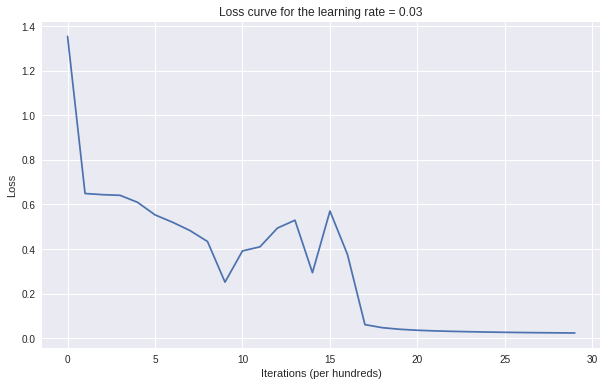

In [9]:
# Setting layers dims
layers_dims = [X_train.shape[0], 5, 5, 1]

# NN with tanh activation fn
parameters_tanh = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000,
    hidden_layers_activation_fn="tanh")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")